In [11]:
# !jupyter nbconvert --to script pack_existing_segs.ipynb

In [12]:
import einops
import os

import matplotlib.pyplot as plt
import numpy as np
from tianshou.policy import PPOPolicy
import uuid
from tianshou.utils import WandbLogger, LazyLogger
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import TimeLimit
from customs import CustomDQNPolicy, CustomOffpolicyTrainer
from dataset import *
from env import *
from networks.q_network import *
from networks.SimpleAC import Actor as SimpleActor, Critic as SimpleCritic
from tianshou.utils.net.common import ActorCritic
from tianshou.utils.net.discrete import Actor, Critic, IntrinsicCuriosityModule
from tianshou.trainer import OnpolicyTrainer
import torch
import tianshou as ts
from networks.AC import Actor as MulActor, Critic as MulCritic, BaseNetwork as MulBaseNetwork
# %matplotlib inline

In [13]:
# if username is server use cuda
if os.environ['USER'] == 'server':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# if __name__ == '__main__':
#     torch.multiprocessing.set_start_method('spawn')

In [14]:
def get_wandb(use_wandb):
    if use_wandb:
        wandb_logger = WandbLogger(
            train_interval=1,
            test_interval=1,
            update_interval=1,
            project="AttentionRL",
        )
        wandb_logger.load(SummaryWriter("./logs"))
    else:
        wandb_logger = LazyLogger()

    return wandb_logger

In [15]:
def get_train_fn(policy, eps_train, inital_phase):
    def train_fn(epoch, env_step):
        if eps_train:
            policy.set_eps(eps_train[epoch - 1])

        if epoch >= inital_phase:
            for param in policy.parameters():
                param.requires_grad = True

        if epoch >= 0 and epoch % 5 == 0 and use_wandb:
            torch.save(policy.state_dict(),
                       f'saved/policy_{wandb_logger.wandb_run.name if use_wandb else uuid.uuid4().hex}.pt')

        wandb_logger.write('train', trainer.env_step, {"epoch": epoch})

    return train_fn

In [16]:
def register_hooks(model):
    hook0 = model.dueling_head.Q.model[-1].register_forward_hook(lambda self, input, output: print(f"Q: {output}"))
    hook1 = model.dueling_head.V.model[-1].register_forward_hook(lambda self, input, output: print(f"V: {output}"))
    # hook2 = model.dueling_head.model.model[0].register_forward_hook(lambda self, input, output: print(f"net: {output}"))


def get_DQN_policy():
    config.update({
        "n_step": 1,
        "target_freq": 1200,
    })

    action_count = len(Actions)
    net = Q_network(action_count).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=config['lr'])
    policy = CustomDQNPolicy(net, optim, discount_factor=config['gamma'], estimation_step=config['n_step'],
                             target_update_freq=config['target_freq'], polyak=None)
    # register_hooks(policy.model)
    return policy


def get_PPO_policy():
    config.update({
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "vf_coef": 0.25,
        "ent_coef": .01,
        "rew_norm": True,
        "eps_clip": 0.1,
        "value_clip": True,
        "dual_clip": None,
        "norm_adv": True,
        "recompute_adv": 0,
    })

    base_net = ViTTrailEncoder()
    actor = Actor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[])
    critic = Critic(base_net, device=device, hidden_sizes=[])    

    # base_net = ViTTrailEncoder()
    # actor = SimpleActor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512])

    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = Actor(base_net, len(Actions), device=device, softmax_output=False)
    # critic = Critic(base_net, device=device)

    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = MulActor(base_net).to(device)
    # critic = MulCritic(base_net).to(device)

    optim = torch.optim.Adam(
        ActorCritic(actor, critic).parameters(), lr=config['lr'], eps=1e-5
    )

    def dist(p):
        return torch.distributions.Categorical(logits=p)

    policy = PPOPolicy(
    # policy = TempPPO(
        actor=actor,
        critic=critic,
        optim=optim,
        dist_fn=dist,
        discount_factor=config['gamma'],
        gae_lambda=config['gae_lambda'],
        max_grad_norm=config['max_grad_norm'],
        vf_coef=config['vf_coef'],
        ent_coef=config['ent_coef'],
        reward_normalization=config['rew_norm'],
        action_scaling=False,
        eps_clip=config['eps_clip'],
        value_clip=config['value_clip'],
        dual_clip=config['dual_clip'],
        advantage_normalization=config['norm_adv'],
        recompute_advantage=config['recompute_adv'],
    ).to(device)
    return policy

In [17]:
from typing import Any, List, Dict
from tianshou.data import Batch


class TempPPO(PPOPolicy):
    def learn(  # type: ignore
            self, batch: Batch, batch_size: int, repeat: int, **kwargs: Any
    ) -> Dict[str, List[float]]:
        losses, clip_losses, vf_losses, ent_losses = [], [], [], []
        for step in range(repeat):
            if self._recompute_adv and step > 0:
                batch = self._compute_returns(batch, self._buffer, self._indices)
            for minibatch in batch.split(batch_size, merge_last=True):
                # calculate loss for actor
                dist = self(minibatch).dist
                if self._norm_adv:
                    mean, std = minibatch.adv.mean(), minibatch.adv.std()
                    minibatch.adv = (minibatch.adv -
                                     mean) / (std + self._eps)  # per-batch norm
                ratio = (dist.log_prob(minibatch.act) -
                         minibatch.logp_old).exp().float()
                ratio = ratio.reshape(ratio.size(0), -1).transpose(0, 1)
                surr1 = ratio * minibatch.adv
                surr2 = ratio.clamp(
                    1.0 - self._eps_clip, 1.0 + self._eps_clip
                ) * minibatch.adv
                if self._dual_clip:
                    clip1 = torch.min(surr1, surr2)
                    clip2 = torch.max(clip1, self._dual_clip * minibatch.adv)
                    clip_loss = -torch.where(minibatch.adv < 0, clip2, clip1).mean()
                else:
                    clip_loss = -torch.min(surr1, surr2).mean()
                # calculate loss for critic
                value = self.critic(minibatch.obs).flatten()
                if self._value_clip:
                    v_clip = minibatch.v_s + \
                             (value - minibatch.v_s).clamp(-self._eps_clip, self._eps_clip)
                    vf1 = (minibatch.returns - value).pow(2)
                    vf2 = (minibatch.returns - v_clip).pow(2)
                    vf_loss = torch.max(vf1, vf2).mean()
                else:
                    vf_loss = (minibatch.returns - value).pow(2).mean()
                # calculate regularization and overall loss

                ent_loss = dist.entropy().mean()
                loss = clip_loss + self._weight_vf * vf_loss \
                       - self._weight_ent * ent_loss
                self.optim.zero_grad()
                loss.backward()
                if self._grad_norm:  # clip large gradient
                    nn.utils.clip_grad_norm_(
                        self._actor_critic.parameters(), max_norm=self._grad_norm
                    )
                self.optim.step()
                clip_losses.append(clip_loss.item())
                vf_losses.append(vf_loss.item())
                ent_losses.append(ent_loss.item())
                losses.append(loss.item())

        return {
            "loss": losses,
            "loss/clip": clip_losses,
            "loss/vf": vf_losses,
            "loss/ent": ent_losses,
        }

In [18]:
def get_offpolicy_trainer(policy):
    replay_buffer = ts.data.VectorReplayBuffer(config['buffer_size'], len(config['train_envs']))
    train_collector = ts.data.Collector(policy, config['train_envs'], replay_buffer, exploration_noise=True)

    config.update({
        "eps_start": 0.9,
        "eps_end": 0.05,
        'update_per_step': 1 / config['step_per_collect'] * 4,
        "eps_train": np.linspace(0.9, 0.05, 2000),
        "eps_test": 0,
    })
    trainer = CustomOffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=None,
        episode_per_test=1, #dummy
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        step_per_collect=config['step_per_collect'],
        batch_size=config['batch_size'],
        update_per_step=config['update_per_step'],
        train_fn=get_train_fn(policy, config['eps_train'], config['initial_phase']),
        test_fn=lambda epoch, env_step: policy.set_eps(config['eps_test']),
        logger=wandb_logger,
    )
    return trainer


def get_onpolicy_trainer(policy):
    replay_buffer = ts.data.VectorReplayBuffer(
        config['buffer_size'],
        len(config['train_envs']),
    )
    train_collector = ts.data.Collector(policy, config['train_envs'], replay_buffer, exploration_noise=True)
    test_collector = ts.data.Collector(policy, config['test_envs'])

    config.update({
        'repeat_per_collect': 1,
        'episode_per_test': 5,
    })

    trainer = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        repeat_per_collect=config['repeat_per_collect'],
        batch_size=config['batch_size'],
        step_per_collect=config['step_per_collect'],
        episode_per_test=config['episode_per_test'],
        train_fn=get_train_fn(policy, None, config['initial_phase']),
        logger=wandb_logger,
    )

    return trainer

In [19]:
if __name__ == "__main__":  ########Policy Initialization########
    config = {
        "lr": 8e-5,
        "epoch": 2000,
        "batch_size": 10,
        "initial_phase": 2000,
        "gamma": 0.98,
        "buffer_size": 10000,
        "step_per_epoch": 2000,
        "env_step_limit": 100,
        "env_step_limit_test": 100,
        "env_step_mem": None,
        "env_patch_size": (32, 32),
        'num_train_envs': 1,
    }
    config['step_per_collect'] = 100 * config['num_train_envs']

    dataset = COCODataset(train=True, indices=[12], no_seg=True)
    
    if config['num_train_envs'] > 1:
        train_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']), config['env_step_limit']) for _ in range(config['num_train_envs'])])
    else:
        train_envs = ts.env.DummyVectorEnv(
            [lambda: TimeLimit(Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']), config['env_step_limit']) for _ in range(1)])
    config['train_envs'] = train_envs
    config['test_envs'] = ts.env.DummyVectorEnv(
        [lambda: TimeLimit(Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']), config['env_step_limit_test']) for _ in range(1)])

    # policy = get_DQN_policy()
    policy = get_PPO_policy()

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['embeddings.mask_token', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
policy.load_state_dict(torch.load("saved/policy_rose-voice-72.pt"))

<All keys matched successfully>

In [ ]:
if __name__ == "__main__":  ########Training########
    use_wandb = True
    wandb_logger = get_wandb(use_wandb)

    # trainer = get_offpolicy_trainer(policy)
    trainer = get_onpolicy_trainer(policy)

    if use_wandb:
        wandb_logger.wandb_run.config.update(config)
    trainer.run()

In [ ]:
    # if __name__ == "__main__":
#     env = TimeLimit(Environment(dataset, (32, 32)), 200)
#     ut.show_masks_on_image(einops.rearrange(env.current_image, 'c h w -> h w c'), env.current_seg.cpu().numpy())
#     plt.show()

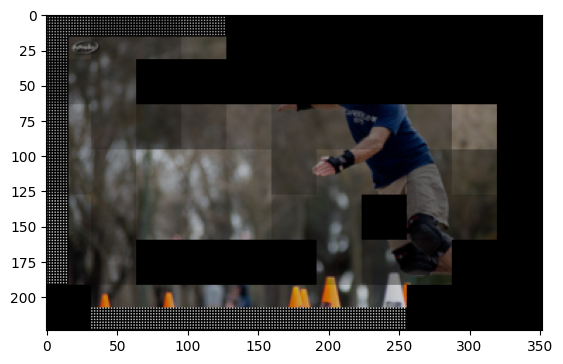

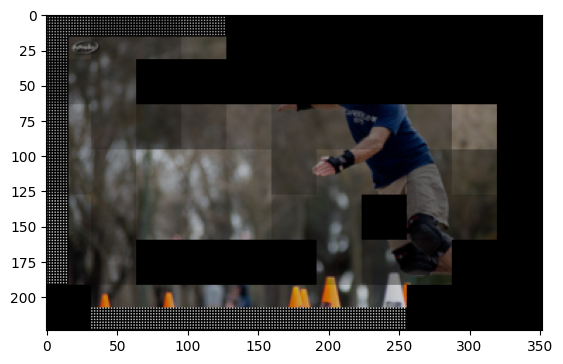

In [22]:
if __name__ == "__main__":
    # dataset = COCODataset(root="../Data/COCO17", train=True, len=1)
    policy.eval()
    # policy.set_eps(config['eps_test'])
    dataset = COCODataset(train=True, indices=[12], no_seg=True)
    env = TimeLimit(Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']), config['env_step_limit'])
    # env = TimeLimit(Environment(dataset, config['env_patch_size']), 100)
    collector = ts.data.Collector(policy, env, exploration_noise=True)
    collector.collect(n_episode=1, render=1 / 5)
    # collector.collect(n_episode=1)